# Assignment 3: Transformer is All You Need

Federico Giorgi (fg2617)

## 1 Basics

In [29]:
# Import all the libraries
import os, math, torch, urllib.request
from dataclasses import dataclass

from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import ByteLevel, Whitespace
from tokenizers.decoders import ByteLevel as ByteLevelDecoder

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device.type)

cuda


## 2 Data Preparation

### 2.1 Corpus loading

The Tiny Shakespeare corpus is downloaded directly from Karpathy’s repository and loaded into memory as a single UTF-8 string. Printing the initial characters serves as a basic integrity check to ensure the file was retrieved correctly.

In [30]:
# Define local path for dataset
TINY_PATH = "tiny_shakespeare.txt"

# Download the Tiny Shakespeare corpus from Karpathy’s repo
urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt",
    TINY_PATH
)

# Read the corpus into memory as a single string
with open(TINY_PATH, "r", encoding="utf-8") as f:
    corpus_text = f.read()

# Print the first 100 characters
print(corpus_text[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


### 2.2 Subword tokenization

A Byte Pair Encoding (BPE) tokenizer with a vocabulary capped at 500 tokens is trained on the corpus. Special tokens for padding, unknown symbols, and sequence boundaries are included. After training, the entire corpus is converted into integer token ids, forming the numerical representation used by the model.

In [31]:
# Define special tokens for padding, unknown words, and sequence boundaries
special_tokens = ["[PAD]", "[UNK]", "[BOS]", "[EOS]"]

# Initialize a Byte Pair Encoding (BPE) tokenizer with an unknown token
tokenizer = Tokenizer(BPE(unk_token="[UNK]"))

# Use GPT-style ByteLevel pre-tokenization (byte-wise mapping + space normalization)
tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
tokenizer.pre_tokenizer = ByteLevel()
tokenizer.decoder = ByteLevelDecoder()

# Train the BPE tokenizer on the corpus, limiting vocabulary size to 500 tokens
trainer = BpeTrainer(vocab_size=500, min_frequency=2, special_tokens=special_tokens)
tokenizer.train_from_iterator([corpus_text], trainer=trainer)

# Retrieve token IDs for the special tokens and vocabulary size
pad_id  = tokenizer.token_to_id("[PAD]")
bos_id  = tokenizer.token_to_id("[BOS]")
eos_id  = tokenizer.token_to_id("[EOS]")
vocab_size = tokenizer.get_vocab_size()

# Encode entire corpus to integer IDs
ids = tokenizer.encode(corpus_text).ids

In [32]:
print("Sanity check 1: encode/decode consistency")

for start in [0, 1000, 5000]:
    snippet = corpus_text[start:start+120]
    decoded = tokenizer.decode(tokenizer.encode(snippet).ids)

    print("\n--- Original ---")
    print(snippet)

    print("\n--- Decoded ---")
    print(decoded)

Sanity check 1: encode/decode consistency

--- Original ---
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved ra

--- Decoded ---
 First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved ra

--- Original ---
Second Citizen:
Would you proceed especially against Caius Marcius?

All:
Against him first: he's a very dog to the comm

--- Decoded ---
 Second Citizen:
Would you proceed especially against Caius Marcius?

All:
Against him first: he's a very dog to the comm

--- Original ---
or heart, the arm our soldier,
Our steed the leg, the tongue our trumpeter.
With other muniments and petty helps
In this

--- Decoded ---
 or heart, the arm our soldier,
Our steed the leg, the tongue our trumpeter.
With other muniments and petty helps
In this


In [33]:
print("\nSanity check 2: ID preservation check")

snippet = corpus_text[2000:2200]

ids_1   = tokenizer.encode(snippet).ids
decoded = tokenizer.decode(ids_1)
ids_2   = tokenizer.encode(decoded).ids

print("IDs identical? ", ids_1 == ids_2)



Sanity check 2: ID preservation check
IDs identical?  True


### 2.3 Sequence formatting

For next-token prediction, the tokenized text is split into overlapping fixed-length windows.
Each window provides an input sequence of length T and a corresponding target sequence shifted by one position. This produces many short supervised examples capturing local context within the corpus.

In [34]:
# For next-token prediction: Input = first N tokens, Target = same sequence shifted by 1

def make_windows(token_ids, seq_len):
    # Total number of tokens in the corpus
    L = len(token_ids)

    # We need i + seq_len + 1 <= L so that both input and target fit
    limit = L - (seq_len + 1)

    # Lists to collect all input and target sequences
    inputs = []
    targets = []

    # Slide a window of size (seq_len + 1) across the corpus with stride 1
    for i in range(0, max(0, limit + 1)):
        # Take a chunk of length seq_len + 1
        seq = token_ids[i : i + seq_len + 1]

        # Input: all tokens except the last one
        inp = seq[:-1]

        # Target: all tokens except the first one (shifted by one position)
        tgt = seq[1:]

        # Append the pair to the dataset lists
        inputs.append(inp)
        targets.append(tgt)

    return inputs, targets

# Generate all (input, target) pairs from the encoded corpus
SEQ_LEN = 50
inputs, targets = make_windows(ids, SEQ_LEN)

In [35]:
# Quick sanity check for the windowed dataset
print(f"Total number of input-target pairs: {len(inputs)}")

# Print the first pair to verify correct shifting
print("\nExample pair:")
print("Input IDs :", inputs[0])
print("Target IDs:", targets[0])

# Decode the first example back to text (optional, for interpretability)
print("\nDecoded example:")
print("Input text :", tokenizer.decode(inputs[0]))
print("Target text:", tokenizer.decode(targets[0]))


Total number of input-target pairs: 517133

Example pair:
Input IDs : [68, 484, 233, 87, 49, 66, 92, 12, 67, 16, 45, 361, 144, 397, 121, 128, 216, 65, 84, 174, 60, 148, 8, 487, 130, 429, 10, 67, 67, 15, 86, 12, 67, 33, 56, 393, 8, 429, 10, 67, 67, 484, 233, 87, 49, 66, 92, 12, 67, 378]
Target IDs: [484, 233, 87, 49, 66, 92, 12, 67, 16, 45, 361, 144, 397, 121, 128, 216, 65, 84, 174, 60, 148, 8, 487, 130, 429, 10, 67, 67, 15, 86, 12, 67, 33, 56, 393, 8, 429, 10, 67, 67, 484, 233, 87, 49, 66, 92, 12, 67, 378, 231]

Decoded example:
Input text :  First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You
Target text: First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are


### 2.4 Train-validation split

The full set of (input, target) pairs is wrapped in a PyTorch Dataset and deterministically divided into an 80/20 train–validation split. Because all sequences have fixed length, batches are created by stacking tensors directly without padding.

In [36]:
# Total number of (input, target) pairs produced by windowing
dataset_size = len(inputs)

# 80/20 split
train_size = int(0.8 * dataset_size)
val_size   = dataset_size - train_size
print(f"Train size: {train_size} | Val size: {val_size}")

Train size: 413706 | Val size: 103427


In [37]:
class NextTokenDataset(Dataset):
    """
    Simple Dataset wrapper for next-token prediction.
    Stores precomputed windows as LongTensors.
    """
    def __init__(self, X, Y):
        # Cast each window to torch.LongTensor (needed by nn.Embedding and CE loss)
        self.X = [torch.tensor(x, dtype=torch.long) for x in X]
        self.Y = [torch.tensor(y, dtype=torch.long) for y in Y]

    def __len__(self):
        # Number of (input, target) pairs
        return len(self.X)

    def __getitem__(self, i):
        # Return one pair shaped (T,), (T,) where T=SEQ_LEN
        return self.X[i], self.Y[i]

# Full dataset (deterministic split via fixed seed)
full_ds = NextTokenDataset(inputs, targets)
train_ds, val_ds = random_split(
    full_ds,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

def collate_batch(batch):
    """
    Collate function for DataLoader.
    Sequences are already fixed-length (SEQ_LEN), so we can stack them directly.

    Input:
        batch: list of N items, each is (x, y) with shape (T,), (T,)
    Output:
        X: (B, T), Y: (B, T)
    """
    # b[0] is input tensor, b[1] is target tensor
    X = torch.stack([b[0] for b in batch], dim=0)  # (B, T)
    Y = torch.stack([b[1] for b in batch], dim=0)  # (B, T)
    return X, Y

BATCH_SIZE = 128

# DataLoaders for training and validation.
# Note: drop_last=True on train for consistent batch size (helps with certain training loops).
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    collate_fn=collate_batch
)

# For validation, keep all examples (no shuffling, no drop_last)
val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_batch
)

In [38]:
# Quick sanity checks
xb, yb = next(iter(train_loader))
print(f"Train batches: {len(train_loader)}  |  Val batches: {len(val_loader)}")
print(f"Batch shapes  -> X: {xb.shape}, Y: {yb.shape}  (expect: ({BATCH_SIZE}, {SEQ_LEN}))")
assert xb.shape == yb.shape == (BATCH_SIZE, SEQ_LEN)

Train batches: 3232  |  Val batches: 809
Batch shapes  -> X: torch.Size([128, 50]), Y: torch.Size([128, 50])  (expect: (128, 50))


### 2.5 Token embedding

Token ids are mapped to continuous vectors through an nn.Embedding layer, producing representations of shape (B,T,d_model). These embeddings form the model’s initial hidden states.

In [39]:
### 1.5 Token embedding (sinusoidal positions only)

# We map token IDs -> dense vectors with nn.Embedding,
# then add fixed (non-trainable) sinusoidal positional encodings à la "Attention Is All You Need".

class TokenEmbedding(nn.Module):
    """
    Token embedding table: converts token IDs to d_model-dimensional vectors.
    """
    def __init__(self, vocab_size: int, d_model: int):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, T) of dtype long
        return self.embed(x)  # (B, T, d_model)


class SinusoidalEmbeddings(nn.Module):
    """
    Fixed sinusoidal positional encodings (no learned parameters).
    Follows Vaswani et al. (2017). Register as a buffer so it moves with .to(device)
    but is excluded from optimizer updates.
    """
    def __init__(self, d_model: int, max_len: int = 10000):
        super().__init__()
        # Create table of shape (max_len, d_model)
        pe = torch.zeros(max_len, d_model, dtype=torch.float32)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)        # (max_len, 1)
        # Frequencies for even/odd dimensions
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # even dims
        pe[:, 1::2] = torch.cos(position * div_term)  # odd dims

        # Register as buffer (not a Parameter): no gradients, moves with the module across devices
        self.register_buffer("pe", pe)  # shape: (max_len, d_model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Add positional encodings for the first T positions.
        x is expected to be (B, T, d_model).
        """
        B, T, D = x.shape
        # Slice the first T rows, then broadcast over batch dimension
        return x + self.pe[:T].unsqueeze(0)  # (1, T, D) + (B, T, D) -> (B, T, D)


# ----- build embeddings and run a quick test on one batch -----
d_model  = 256
max_len  = max(SEQ_LEN, 512)  # keep some headroom if you later increase context length

tok_emb  = TokenEmbedding(vocab_size, d_model).to(device)
pos_enc  = SinusoidalEmbeddings(d_model, max_len=max_len).to(device)

# Fetch one batch of IDs (B, T)
xb, yb = next(iter(train_loader))
xb = xb.to(device)  # (B, T)

# Token embeddings: (B, T, d_model)
h_tok = tok_emb(xb)

# Add sinusoidal positions: (B, T, d_model)
h = pos_enc(h_tok)

In [40]:
print("Sanity checks for embeddings + sinusoidal positions:")
print(" - xb dtype / shape:", xb.dtype, xb.shape)
print(" - token only     :", h_tok.shape)
print(" - token+position :", h.shape)

# 1) Shapes must match
assert h_tok.shape == (xb.size(0), xb.size(1), d_model)
assert h.shape     == (xb.size(0), xb.size(1), d_model)

# 2) Positional buffer should not require gradients
assert pos_enc.pe.requires_grad is False

# 3) Same position across different sequences has identical positional vector
#    (i.e., h[b, t, :] - h_tok[b, t, :] equals the same vector for all b, fixed t)
with torch.no_grad():
    t = 0  # check the first position; you can try other t as well
    pos_vecs = h[:, t, :] - h_tok[:, t, :]              # (B, D)
    diff = (pos_vecs - pos_vecs[0]).abs().max().item()  # max deviation from the first sample
    print(f" - max deviation of pos[t={t}] across batch: {diff:.3e}")
    assert diff < 1e-6

# 4) Different positions within the same sequence must have different positional vectors
with torch.no_grad():
    if xb.size(1) >= 2:
        # Compare pos enc at t=0 vs t=1 for the first sample in batch
        v0 = h[0, 0, :] - h_tok[0, 0, :]
        v1 = h[0, 1, :] - h_tok[0, 1, :]
        cosine = torch.nn.functional.cosine_similarity(v0, v1, dim=0).item()
        print(f" - cosine similarity between pos[0] and pos[1]: {cosine:.4f} (should be < 1.0)")

Sanity checks for embeddings + sinusoidal positions:
 - xb dtype / shape: torch.int64 torch.Size([128, 50])
 - token only     : torch.Size([128, 50, 256])
 - token+position : torch.Size([128, 50, 256])
 - max deviation of pos[t=0] across batch: 2.980e-07
 - cosine similarity between pos[0] and pos[1]: 0.9721 (should be < 1.0)


## 3 Tiny Transformer Implementation

### 3.1 Transformer Structure

In [41]:
class SelfAttention(nn.Module):
    """Self-attention with causal masking"""
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x):
        batch_size, seq_len, d_model = x.shape

        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)

        scores = Q @ K.transpose(-2, -1) / (d_model ** 0.5)

        # Causal mask
        mask = torch.tril(torch.ones(seq_len, seq_len)).to(x.device)
        scores = scores.masked_fill(mask == 0, float('-inf'))

        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = torch.nan_to_num(attn_weights, 0.0)

        output = attn_weights @ V
        return output, attn_weights


class FeedForward(nn.Module):
    """Two-layer MLP"""
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.fc2(F.relu(self.fc1(x)))


class TransformerBlock(nn.Module):
    """One transformer block: Attention + FFN + Residuals"""
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.attention = SelfAttention(d_model)
        self.ffn = FeedForward(d_model, d_ff)

        # RMSNorm
        self.norm1 = nn.RMSNorm(d_model)
        self.norm2 = nn.RMSNorm(d_model)

    def forward(self, x):
        # Pre-norm attention
        h = self.norm1(x)
        attn_out, attn_weights = self.attention(h)
        x = x + attn_out   # residual connection

        # Pre-norm feed-forward
        h2 = self.norm2(x)
        ffn_out = self.ffn(h2)
        x = x + ffn_out    # residual connection

        return x, attn_weights


class TinyTransformer(nn.Module):
    """Complete transformer model"""
    def __init__(self, vocab_size, d_model, n_layers, d_ff, max_seq_len=128):
        super().__init__()
        self.token_embedding = TokenEmbedding(vocab_size, d_model)
        self.pos_encoding = SinusoidalEmbeddings(
            d_model=d_model,
            max_len=max_seq_len
        )

        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, d_ff) for _ in range(n_layers)
        ])

        self.output_layer = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        # Token embeddings: (B, T, d_model)
        x = self.token_embedding(x)

        # Add fixed sinusoidal positional encodings: still (B, T, d_model)
        x = self.pos_encoding(x)

        all_attn = []
        for block in self.blocks:
            x, attn = block(x)
            all_attn.append(attn)

        logits = self.output_layer(x)  # (B, T, vocab_size)
        return logits, all_attn

### 3.2 Training procedure

In [42]:
d_model = 128
n_layers = 2
d_ff = 512
learning_rate = 1e-3
n_epochs = 50
batch_size = BATCH_SIZE

model = TinyTransformer(vocab_size, d_model, n_layers, d_ff, max_seq_len=SEQ_LEN).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

use_amp = device.type == "cuda"
scaler = GradScaler(enabled=use_amp)

print("\n" + "="*70)
print("MODEL ARCHITECTURE")
print("="*70)
print(f"Embedding dim: {d_model}")
print(f"Layers: {n_layers}")
print(f"FFN hidden: {d_ff}")
print(f"Batch size: {batch_size}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Epochs: {n_epochs}")

train_losses = []
val_losses = []
val_ppl_list = []

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0

    for xb, yb in train_loader:
        xb = xb.to(device)            # (B, T)
        yb = yb.to(device)            # (B, T)

        optimizer.zero_grad()

        with autocast(enabled=use_amp):
            logits, _ = model(xb)     # (B, T, vocab_size)
            loss = criterion(
                logits.view(-1, vocab_size),
                yb.view(-1)
            )

        if use_amp:
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits, _ = model(xb)
            loss = criterion(
                logits.view(-1, vocab_size),
                yb.view(-1)
            )
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    val_ppl = math.exp(avg_val_loss)
    val_ppl_list.append(val_ppl)

    print(f"Epoch {epoch+1:3d}/{n_epochs} | train loss: {avg_train_loss:.4f} | val loss: {avg_val_loss:.4f} | val PPL: {val_ppl:.2f}")

print("\nTraining finished!")

final_val_loss = val_losses[-1]
final_val_ppl = math.exp(final_val_loss)
print(f"\nFinal validation loss: {final_val_loss:.4f}")
print(f"Final validation perplexity: {final_val_ppl:.2f}")




MODEL ARCHITECTURE
Embedding dim: 128
Layers: 2
FFN hidden: 512
Batch size: 128
Parameters: 490,740
Epochs: 50


/tmp/ipython-input-763539771.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp)
/tmp/ipython-input-763539771.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch   1/50 | train loss: 2.9285 | val loss: 2.5790 | val PPL: 13.18
Epoch   2/50 | train loss: 2.4569 | val loss: 2.3611 | val PPL: 10.60
Epoch   3/50 | train loss: 2.2917 | val loss: 2.2459 | val PPL: 9.45
Epoch   4/50 | train loss: 2.1946 | val loss: 2.1737 | val PPL: 8.79
Epoch   5/50 | train loss: 2.1290 | val loss: 2.1171 | val PPL: 8.31
Epoch   6/50 | train loss: 2.0809 | val loss: 2.0796 | val PPL: 8.00
Epoch   7/50 | train loss: 2.0433 | val loss: 2.0456 | val PPL: 7.73
Epoch   8/50 | train loss: 2.0126 | val loss: 2.0139 | val PPL: 7.49
Epoch   9/50 | train loss: 1.9876 | val loss: 1.9910 | val PPL: 7.32
Epoch  10/50 | train loss: 1.9669 | val loss: 1.9779 | val PPL: 7.23
Epoch  11/50 | train loss: 1.9491 | val loss: 1.9602 | val PPL: 7.10
Epoch  12/50 | train loss: 1.9333 | val loss: 1.9447 | val PPL: 6.99
Epoch  13/50 | train loss: 1.9200 | val loss: 1.9292 | val PPL: 6.88
Epoch  14/50 | train loss: 1.9079 | val loss: 1.9163 | val PPL: 6.80
Epoch  15/50 | train loss: 1.897

## 4 Visualization & Interpretation

### 4.1 Training and validation loss curves

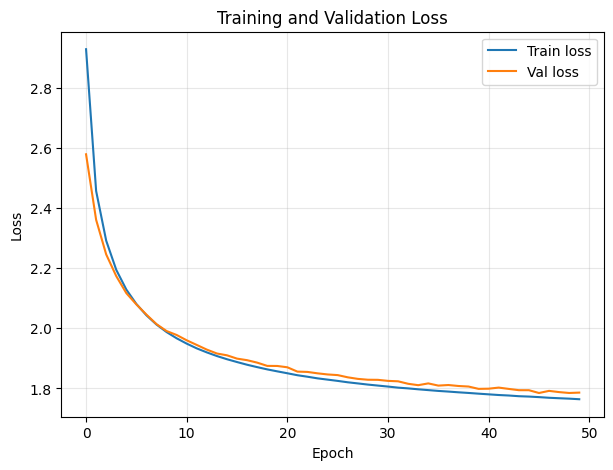

In [43]:
plt.figure(figsize=(7,5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### 4.2 Attention Heatmap

In [44]:
def plot_attention(layer_idx):
  model.eval()

  # Take one batch from the validation loader
  xb, yb = next(iter(val_loader))
  xb = xb.to(device)

  # Forward pass with attention collection enabled
  with torch.no_grad():
      logits, all_attn = model(xb)

  # Select the first sequence in the batch
  seq_tokens = xb[0] # shape: (T,)
  seq_tokens_cpu = seq_tokens.cpu().tolist()

  # Choose which layer’s attention to visualize (e.g., first layer)
  attn = all_attn[layer_idx][0]    # shape: (T, T) for the first example
  attn = attn.detach().cpu().numpy()

  # Plot the attention matrix
  plt.figure(figsize=(7, 5))
  plt.imshow(attn, aspect="auto", origin="upper")
  plt.colorbar()
  plt.title(f"Attention Heatmap: Layer {layer_idx}")

  # For HuggingFace `tokenizers` library: tokenizer.id_to_token(id)
  token_strs = [tokenizer.id_to_token(t) for t in seq_tokens_cpu]

  T = len(token_strs)
  plt.xticks(range(T), token_strs, rotation=90, fontsize=6)
  plt.yticks(range(T), token_strs, fontsize=6)

  plt.tight_layout()
  plt.show()

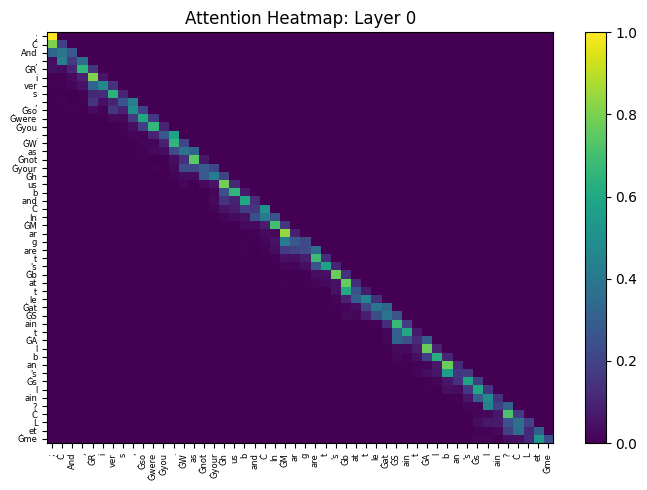

In [45]:
plot_attention(0)

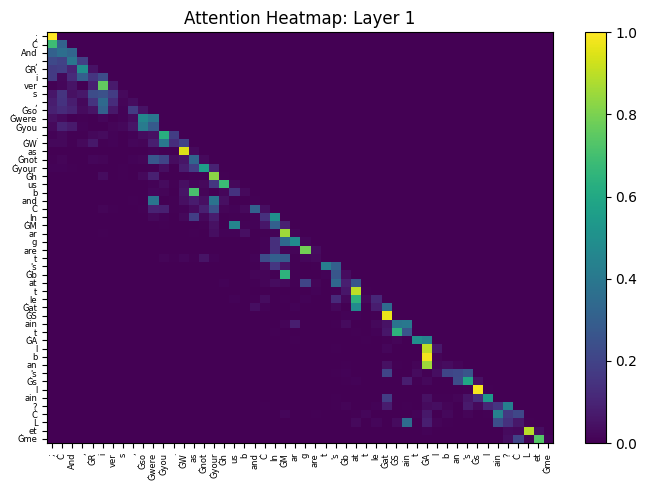

In [46]:
plot_attention(1)

### 4.3 Validation Perplexity

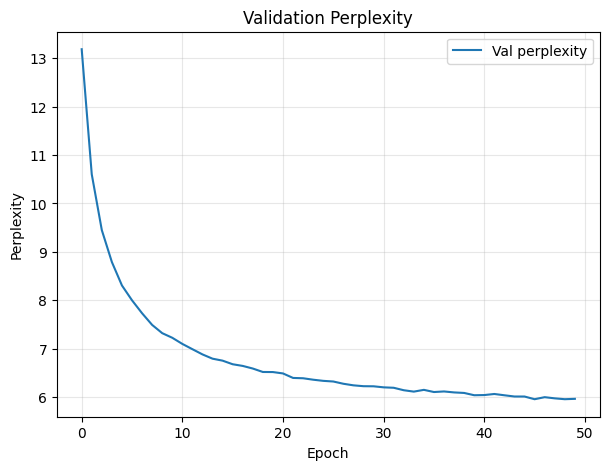

In [47]:
plt.figure(figsize=(7,5))
plt.plot(val_ppl_list, label="Val perplexity")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title("Validation Perplexity")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### 4.4 Sample generations

In [48]:
def generate_text(model, tokenizer, prompt, max_new_tokens=50, temperature=1.0):
    model_was_training = model.training
    model.eval()

    device = next(model.parameters()).device

    # Encode prompt into token IDs
    input_ids = tokenizer.encode(prompt).ids

    # Keep only the last SEQ_LEN tokens if the prompt is long
    input_ids = input_ids[-SEQ_LEN:]

    # (1, T)
    x = torch.tensor(input_ids, dtype=torch.long, device=device).unsqueeze(0)

    with torch.no_grad():
        for _ in range(max_new_tokens):
            # Maintain the sliding window
            if x.size(1) > SEQ_LEN:
                x = x[:, -SEQ_LEN:]

            # Forward pass
            logits, _ = model(x)

            # Take logits for the last position
            logits = logits[:, -1, :]

            # Apply temperature
            logits = logits / temperature

            # Convert logits to probabilities
            probs = F.softmax(logits, dim=-1)

            # Sample next token ID
            next_id = torch.multinomial(probs, num_samples=1)

            # Append token
            x = torch.cat([x, next_id], dim=1)

    # Convert tensor back to Python list
    out_ids = x[0].cpu().tolist()

    # Extract only the generated continuation
    gen_ids = out_ids[len(input_ids):]

    # Decode IDs into text
    gen_text = tokenizer.decode(gen_ids)

    if model_was_training:
        model.train()

    return gen_text

In [49]:
prompt = "ROMEO:\n"
output = generate_text(model, tokenizer, prompt, max_new_tokens=80, temperature=0.8)
print(output)

 behold his news love again,
Another beguphlean to the church,
Pertended to make you wit chance 't


In [50]:
prompt = "CLAUDIO:\n"
output = generate_text(model, tokenizer, prompt, max_new_tokens=80, temperature=0.8)
print(output)

 have with thy mere patient to some native jary
I' the like rebels of your blood fair sieb and a fair transes


In [51]:
prompt = "Help!:\n"
output = generate_text(model, tokenizer, prompt, max_new_tokens=80, temperature=0.8)
print(output)

, my Lord of Derby?

QUEEN ELIZABETH:
As he is breathe the wave-born bridegroom from


In [52]:
prompt = "I love:\n"
output = generate_text(model, tokenizer, prompt, max_new_tokens=80, temperature=0.8)
print(output)

est growing souls,
Do yes, speak not the same intent,
No never with a mildness; for, in warm'd
From d
